In [ ]:
"""
### Assignment 2: Frequency Domain Signal Analysis
**Duration:** 60-75 minutes  
**Difficulty:** ⭐⭐⭐☆☆

#### Objectives
- Master frequency domain interpretation of real signals
- Understand windowing and spectral leakage
- Build intuition for spectrograms and time-frequency analysis

#### Tasks
1. **Signal generation and analysis:**
   ```python
   # Create composite signal
   fs = 1000  # Sample rate
   t = np.linspace(0, 2, 2*fs)
   signal = (2*np.cos(2*np.pi*50*t) + 
            0.5*np.cos(2*np.pi*120*t) + 
            0.1*np.random.randn(len(t)))
   ```

2. **Spectral analysis:**
   - Compute and plot magnitude spectrum
   - Identify frequency peaks and relate to original components
   - Calculate signal power in different frequency bands
   - Analyze effect of signal length on frequency resolution

3. **Windowing investigation:**
   - Apply different windows: rectangular, Hann, Hamming, Blackman
   - Compare spectral leakage for each window
   - Demonstrate window choice trade-offs (main lobe vs side lobes)

4. **Time-varying signals:**
   - Create chirp signal (frequency sweeping over time)
   - Implement short-time FFT (spectrogram)
   - Analyze signals with time-varying frequency content

#### Expected Output
- Function: `analyze_spectrum()`, `apply_windowing()`, `compute_spectrogram()`
- Plots: Spectrum plots, window comparisons, spectrograms
- Analysis: Written comparison of different windowing effects

#### Key Insights to Gain
- Real signals have noise and multiple frequency components
- Windowing is essential for analyzing finite-length signals
- Time-frequency trade-off in spectral analysis

---

"""

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Literal
from scipy.signal.windows import tukey


In [13]:

def plot_function(
    x: np.ndarray, 
    y: np.ndarray, 
    title: str, 
    x_title: str | None = None, 
    y_title: str | None = None
):
    fig, ax = plt.subplots()
    ax.plot(x, y, markeredgewidth=1)
    ax.set_title(title)
    if y_title:
        ax.set_ylabel(y_title)
    if x_title:
        ax.set_xlabel(x_title)

    plt.show()

def plot_multiple(pairs: list[tuple[np.ndarray, np.ndarray]], title: str):
    fig, ax = plt.subplots()
    for x, y in pairs:
        ax.plot(x, y, markeredgewidth=1)
    ax.set_title(title)
    # if y_title:
    #     ax.set_ylabel(y_title)
    # if x_title:
    #     ax.set_xlabel(x_title)
    plt.show()

In [14]:
# 1. **Signal generation and analysis:**
fs = 1000  # Sample rate
t = np.linspace(0, 2, 2*fs)
signal = (2*np.cos(2*np.pi*50*t) + 
        0.5*np.cos(2*np.pi*120*t) + 
        0.1*np.random.randn(len(t)))

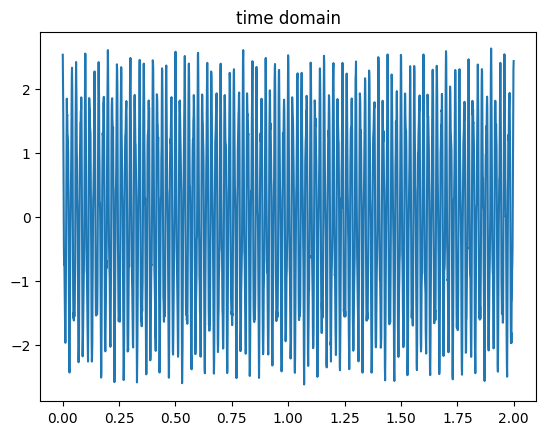

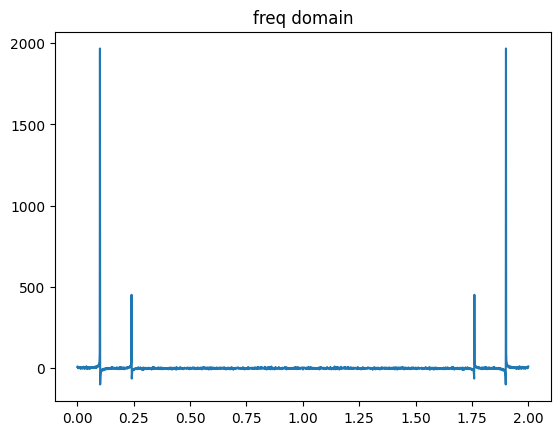

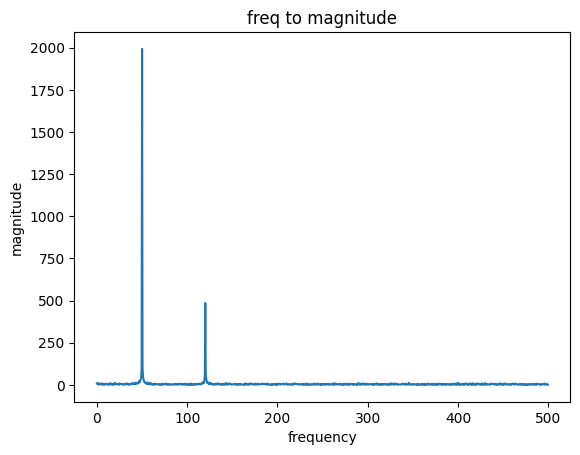

In [30]:
"""
2. **Spectral analysis:**
   - Compute and plot magnitude spectrum
   - Identify frequency peaks and relate to original components
   - Calculate signal power in different frequency bands
   - Analyze effect of signal length on frequency resolution
"""
# to compute magnitude ans strength we need ftt

X = np.fft.fft(signal)
N = len(signal)
magnitude = np.abs(X[: N // 2]) # only positive frequencies
frequencies = np.fft.fftfreq( N, 1/fs)[: N // 2]

# 3. Plot magnitude spectrum
plot_function(t, signal, 'time domain')
plot_function(t, X, 'freq domain')
plot_function(frequencies, magnitude, 'freq to magnitude', x_title='frequency', y_title='magnitude')

# plot_function(t, signal, 'time domain')
# plot_function(t, X, 'freq domain')

power for Low (0 - 100): 8017632.624182359
power for Mid (100 - 200): 505917.64213485474
power for High (200 - 400): 15422.625334739765
Time domain power: 2.1368205033355525
Freq domain power: 8538972.891651955
Low (0 - 100): 93.9% of total power
Mid (100 - 200): 5.9% of total power
High (200 - 400): 0.2% of total power


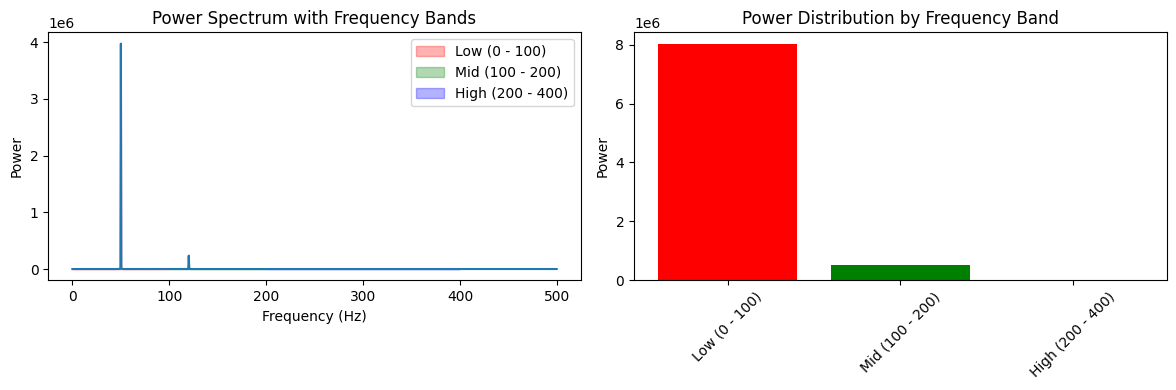

In [32]:

# 4. Calculate signal power in different frequency bands
power_spectrum = np.abs(X)**2
positive_power_spectrum = power_spectrum[: N // 2]

# frequency bands:
bands = {
    'Low (0 - 100)': (0, 100),
    'Mid (100 - 200)': (100, 200),
    'High (200 - 400)': (200, 400),
}
band_powers = { }

for name, (low, high) in bands.items():
    band_mask = (frequencies >= low) &  (frequencies <=high)
    # sum power in the band, multiply by 2 for single sided specgtrum (our case)
    band_power = 2 * np.sum(positive_power_spectrum[band_mask])
    band_powers[name] = band_power
    print(f'power for {name}: {band_power}')

# verify with total signal power (time domain)
sig_power = np.mean(signal**2)
freq_domain_power = sum(band_powers.values())
print(f'Time domain power: {sig_power}')
print(f'Freq domain power: {freq_domain_power}')
# positive frequencies

# Calculate percentage of total power in each band
total_power = sum(band_powers.values())
power_percentages = {
   band: (power/total_power) * 100
   for band, power in band_powers.items()
}

for band, percentage in power_percentages.items():
   print(f"{band}: {percentage:.1f}% of total power")



# 3. Visualization Approach

  # Create a bar chart of power distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot power spectrum with band regions
ax1.plot(frequencies, positive_power_spectrum)
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Power')
ax1.set_title('Power Spectrum with Frequency Bands')

# Shade the bands
colors = ['red', 'green', 'blue']
for (band_name, (f_low, f_high)), color in zip(bands.items(), colors):
   band_mask = (frequencies >= f_low) & (frequencies < f_high)
   ax1.fill_between(frequencies[band_mask],
                     positive_power_spectrum[band_mask],
                     alpha=0.3, color=color, label=band_name)
ax1.legend()

# Bar chart of power per band
ax2.bar(band_powers.keys(), band_powers.values(), color=colors)
ax2.set_ylabel('Power')
ax2.set_title('Power Distribution by Frequency Band')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#

In [60]:
def apply_windowing(signal: np.ndarray, t: np.ndarray, func_name: Literal['rectangular', 'hanning', 'tukey']) -> np.ndarray:
    """
    3. **Windowing investigation:**
    - Apply different windows: rectangular, Hann, Hamming, Blackman
    - Compare spectral leakage for each window
    - Demonstrate window choice trade-offs (main lobe vs side lobes)
    """

    win_func = {
        'rectangular': np.ones(len(t)),
        'hanning': np.hanning(len(t)),
        'tukey': tukey(len(t), 0.5)
    }.get(func_name)
    return signal * win_func


    

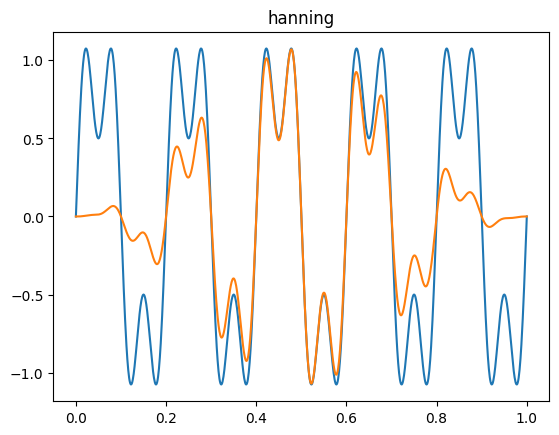

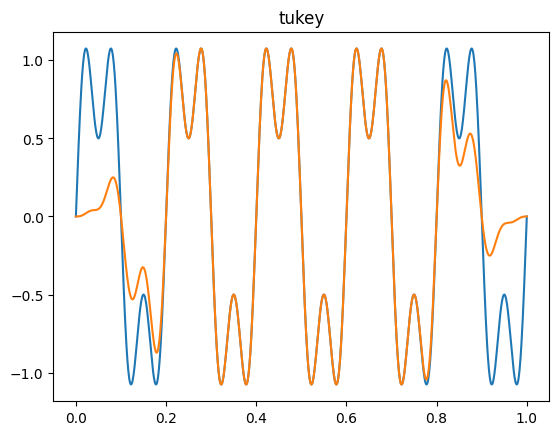

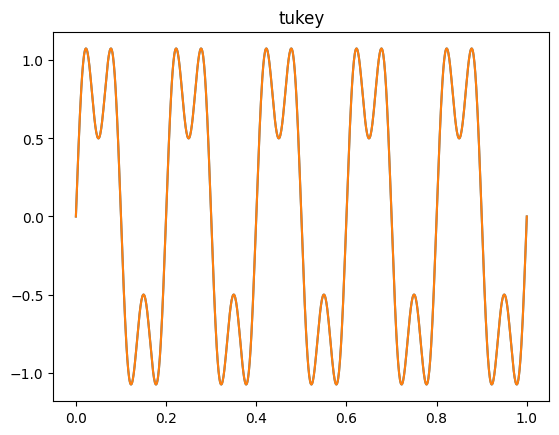

In [61]:

plot_multiple([(t, signal),(t, apply_windowing(signal, t, 'hanning'))], title='hanning')
plot_multiple([(t, signal),(t, apply_windowing(signal, t, 'tukey'))], title='tukey')
plot_multiple([(t, signal),(t, apply_windowing(signal, t, 'rectangular'))], title='tukey')

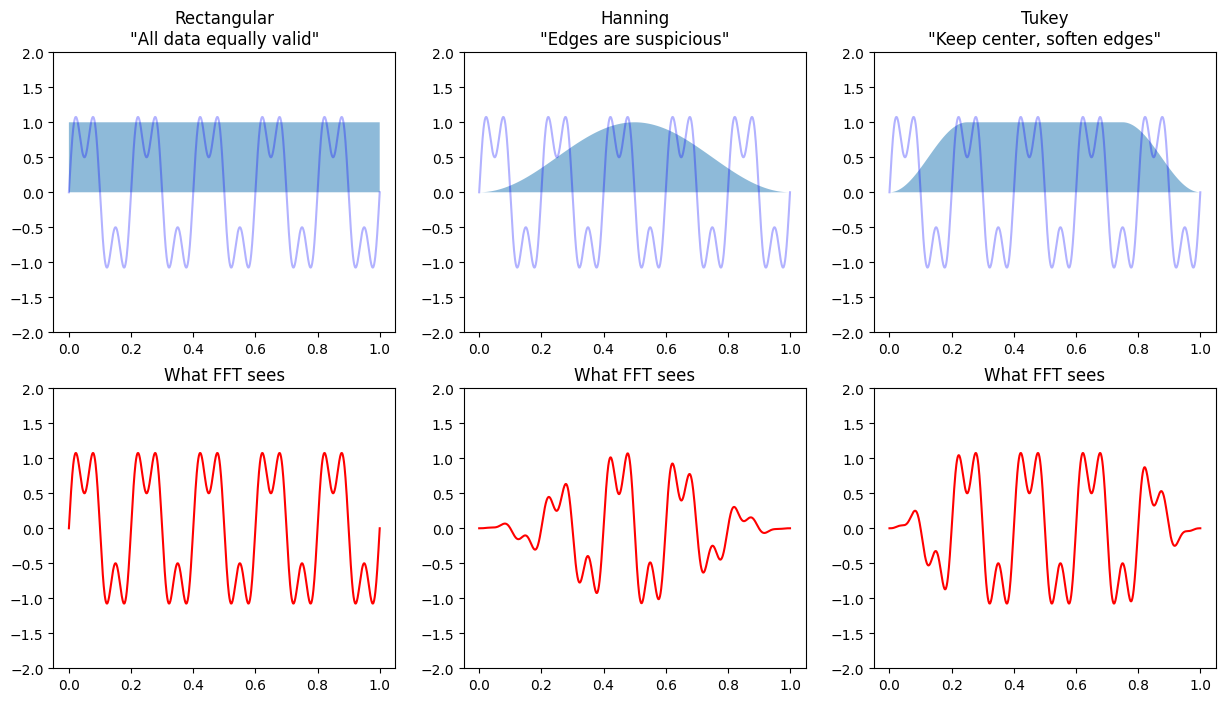

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

# Visualize the "perspective" concept
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

t = np.linspace(0, 1, 1000)
signal = np.sin(2*np.pi*5*t) + 0.5*np.sin(2*np.pi*15*t)

perspectives = {
    'Rectangular\n"All data equally valid"': np.ones(len(t)),
    'Hanning\n"Edges are suspicious"': np.hanning(len(t)),
    'Tukey\n"Keep center, soften edges"': scipy.signal.windows.tukey(len(t), 0.5)
}

for idx, (name, window) in enumerate(perspectives.items()):
    # Show the window (perspective)
    axes[0, idx].fill_between(t, 0, window, alpha=0.5)
    axes[0, idx].plot(t, signal, 'b-', alpha=0.3, label='Original signal')
    axes[0, idx].set_title(name)
    axes[0, idx].set_ylim([-2, 2])

    # Show what we "see" through this perspective
    windowed = signal * window
    axes[1, idx].plot(t, windowed, 'r-')
    axes[1, idx].set_title('What FFT sees')
    axes[1, idx].set_ylim([-2, 2])